In [2]:
import numpy as np
import cvxpy as cp
#import sklearn
import math

Data columns:  ['cases', 'hospitalizations', 'deaths']
Max Daily Deaths:  4475.0


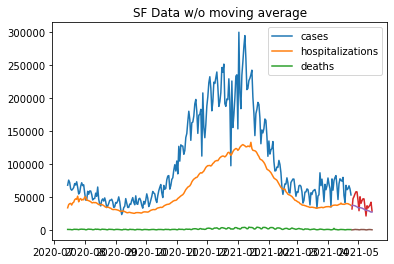

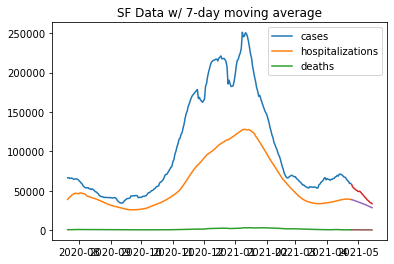

In [5]:
import sys, os
sys.path.append('../')
import numpy as np
import matplotlib.pyplot as plt
from src import utils

# load data from processed csv
path_loc = '../datasets/processed/united_states.csv'
data, dates, columns = utils.read_csv(path_loc)
print("Data columns: ", columns)
print("Max Daily Deaths: ", data[:,2].max())

# without averaging

train, test, train_dates, test_dates = utils.train_test_split(data, dates)

plt.figure()
plt.title('SF Data w/o moving average')
plt.plot(train_dates, train)
plt.plot(test_dates, test)
plt.legend(columns)
plt.show()

# with 7-day moving average
mva_data, mva_dates = utils.moving_average(data, dates, days=7)
train, test, train_dates, test_dates = utils.train_test_split(mva_data, mva_dates)

plt.figure()
plt.title('SF Data w/ 7-day moving average')
plt.plot(train_dates, train)
plt.plot(test_dates, test)
plt.legend(columns)
plt.show()


In [44]:
print(columns)
print(train.shape)
print(train[100])

['cases', 'hospitalizations', 'deaths']
(278, 3)
[77360.         41430.57142857   846.42857143]


usage: ipykernel_launcher.py [-h] --country COUNTRY [COUNTRY ...]
ipykernel_launcher.py: error: the following arguments are required: --country


SystemExit: 2

/Users/agraur/anaconda3/envs/covid/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3445: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [78]:
def estimate_params2(V, U):
    if len(V) != len(U):
        raise ValueError("Arrays must have the same size")
    T = len(V)
    
    '''
    gammas = cp.Variable(2)
    constraints = [gammas >= 0.01]
    expression = 0
    for d in range(T-1):
        #expression += cp.sum_squares(np.array([V[d+1], U[d+1]]) - gammas @ np.array([V[d], U[d]]))
        expression += cp.square(V[d+1] - (U[d] + V[d]) * gammas[0])
        expression += cp.square(U[d+1] - (U[d] + V[d]) * gammas[1])
    problem = cp.Problem(cp.Minimize(expression), constraints)
    problem.solve(solver = cp.ECOS)
    '''
    
    gammas = np.ones(2)
    iters = 1000
    for i in range(iters):
        grad = np.zeros(2)
        for t in range(T-1):
            grad[0] += (U[t] + V[t]) * (gammas[0] - V[t+1])
            grad[1] += (U[t] + V[t]) * (gammas[1] - U[t+1])
        gammas = gammas - grad * (0.5 / (i+1))
    
    #opt_val = gammas.value
    
    return gammas

In [14]:
def estimate_params4(V, U):
    if len(V) != len(U):
        raise ValueError("Arrays must have the same size")
    T = len(V)
    #gammas = np.ones((2, 2))
    gammas = cp.Variable((2, 2))
    constraints = [gammas >= 0.01]
    expression = 0
    for d in range(T-1):
        expression += cp.sum_squares(np.array([V[d+1], U[d+1]]) - gammas @ np.array([V[d], U[d]]))
    problem = cp.Problem(cp.Minimize(expression), constraints)
    problem.solve(solver = cp.ECOS)
    
    opt_val = gammas.value
    
    return opt_val

In [15]:
def l1_estimate_params4(V, U, lbd):
    if len(V) != len(U):
        raise ValueError("Arrays must have the same size")
    T = len(V)
    
    gammas = cp.Variable((T, 4))
    constraints = [gammas >= 0.01]
    expression = 0
    for d in range(T-1):
        expression += cp.square(V[d+1] - gammas[d, 0] * V[d] - gammas[d, 1] * U[d])
        expression += cp.square(U[d+1] - gammas[d, 2] * V[d] - gammas[d, 3] * U[d])
        expression += lbd * cp.norm(gammas[d] - gammas[d+1], 1)
    
    problem = cp.Problem(cp.Minimize(expression), constraints)
    problem.solve(solver = cp.ECOS_BB, verbose = True)
    
    opt_val = gammas.value
    
    return opt_val

In [27]:
def l1_estimate_params2(V, U, lbd):
    if len(V) != len(U):
        raise ValueError("Arrays must have the same size")
    T = len(V)
    
    gammas = cp.Variable((T, 2))
    constraints = [gammas >= 0.01]
    expression = 0
    for d in range(T-1):
        expression += cp.square(V[d+1] - gammas[d, 0] * (U[d] + V[d]))
        expression += cp.square(U[d+1] - gammas[d, 1] * (U[d] + V[d]))
        expression += lbd * cp.norm(gammas[d] - gammas[d+1], 1)
    
    problem = cp.Problem(cp.Minimize(expression), constraints)
    problem.solve()
    
    opt_val = gammas.value
    
    return opt_val

In [17]:
def delta_estimate_params4(delta, V, U):
    if len(V) != len(U):
        raise ValueError("Arrays must have the same size")
    T = len(V)
    gammas = cp.Variable((T, 4))
    constraints = [gammas >= 0.001]
    for d in range(T-1):
        constraints += [cp.norm(gammas[d+1,:]-gammas[d,:],'inf') <= delta]
    expression = 0
    for d in range(T-1):
        expression += cp.square(V[d+1] - gammas[d, 0] * V[d] - gammas[d, 1] * U[d])
        expression += cp.square(U[d+1] - gammas[d, 2] * V[d] - gammas[d, 3] * U[d])
        #expression += cp.sum_squares(np.array([V[d+1], U[d+1]]) - gammas[d,:] @ np.array([V[d], U[d]]))
    problem = cp.Problem(cp.Minimize(expression), constraints)
    problem.solve(solver = cp.ECOS, max_iters = 10000)

    opt_val = gammas.value
  
    return opt_val

In [18]:
def delta_estimate_params2(delta, V, U):
    if len(V) != len(U):
        raise ValueError("Arrays must have the same size")
    T = len(V)
    gammas = cp.Variable((T, 2))
    constraints = [gammas >= 0.001]
    for d in range(T-1):
        constraints += [cp.norm(gammas[d+1,:]-gammas[d,:],'inf') <= delta]
    expression = 0
    for d in range(T-1):
        expression += cp.square(V[d+1] - gammas[d, 0] * (V[d] + U[d]))
        expression += cp.square(U[d+1] - gammas[d, 1] * (V[d] + U[d]))
        #expression += cp.sum_squares(np.array([V[d+1], U[d+1]]) - gammas[d,:] @ np.array([V[d], U[d]]))
    problem = cp.Problem(cp.Minimize(expression), constraints)
    problem.solve(solver = cp.ECOS, max_iters = 10000)

    opt_val = gammas.value
  
    return opt_val

In [79]:
true_gammas = np.array([0.15, 1.05])
true_gammas

array([0.15, 1.05])

In [83]:
T = 25
U = np.zeros(T)
V = np.zeros(T)
V[0] = 2
U[0] = 5
'''
for i in range(T-1):
    sigma = 0.001
    I = U[i] + V[i]
    noise1 = np.random.normal(0, sigma * np.sqrt(V[i]))
    noise2 = np.random.normal(0, sigma * np.sqrt(U[i]))
    V[i+1] = V[i] * true_gammas[0, 0] + U[i] * true_gammas[0, 1] + noise1
    U[i+1] = V[i] * true_gammas[1, 0] + U[i] * true_gammas[1, 1] + noise2
'''
for i in range(T-1):
    sigma = 1
    I = U[i] + V[i]
    noise1 = max(0, np.random.normal(0, sigma * np.sqrt(I)))
    noise2 = max(0, np.random.normal(0, sigma * np.sqrt(I)))
    V[i+1] = I * true_gammas[0] + noise1
    U[i+1] = I * true_gammas[1] + noise2


In [90]:
lbd = 100
gammaest = l1_estimate_params2(V, U, lbd)
gammaest

array([[0.21199293, 1.07465505],
       [0.21199293, 1.07465505],
       [0.21199293, 1.07465505],
       [0.21199293, 1.07465505],
       [0.21199293, 1.07465505],
       [0.23436272, 1.07465505],
       [0.24419071, 1.07465505],
       [0.17759417, 1.11722458],
       [0.16570143, 1.24391683],
       [0.20043764, 1.05790198],
       [0.15499048, 1.1688114 ],
       [0.15503571, 1.20882486],
       [0.15019412, 1.05152964],
       [0.15019412, 1.07653736],
       [0.15019412, 1.0792476 ],
       [0.15019412, 1.1027316 ],
       [0.1995738 , 1.05029754],
       [0.15019046, 1.09083338],
       [0.17269328, 1.05607521],
       [0.15008189, 1.05008189],
       [0.17476273, 1.08629526],
       [0.16141843, 1.05003575],
       [0.16857876, 1.06357255],
       [0.15000802, 1.07485545],
       [0.15000802, 1.07485545]])

Dynamic gammas generation

In [92]:
dynamic_gammas = np.empty((T, 2))

dynamic_gammas[0, 0] = 0.15
dynamic_gammas[0, 1] = 1.05

for t in range(T - 1):
    dynamic_gammas[t+1, 0] =dynamic_gammas[t, 0] + 0.005
    dynamic_gammas[t+1, 1] =dynamic_gammas[t, 1] + 0.002

In [93]:
U = np.zeros(T)
V = np.zeros(T)
V[0] = 2
U[0] = 5

for i in range(T-1):
    sigma = 0.1
    I = U[i] + V[i]
    noise1 = max(0, np.random.normal(0, sigma * np.sqrt(I)))
    noise2 = max(0, np.random.normal(0, sigma * np.sqrt(I)))
    V[i+1] = I * dynamic_gammas[i, 0] + noise1
    U[i+1] = I * dynamic_gammas[i, 1] + noise2

In [98]:
lbd = 100
gammaest = l1_estimate_params2(V, U, lbd)
gammaest

array([[0.19800241, 1.07446938],
       [0.19800241, 1.07446938],
       [0.19800241, 1.07446938],
       [0.19800241, 1.07446938],
       [0.19800241, 1.07446938],
       [0.19800241, 1.07446938],
       [0.19800241, 1.07446938],
       [0.19800241, 1.07446938],
       [0.19800241, 1.07446938],
       [0.19800241, 1.07446938],
       [0.19999999, 1.07446938],
       [0.205     , 1.07717808],
       [0.21      , 1.07717808],
       [0.2176883 , 1.07717808],
       [0.22007794, 1.07799999],
       [0.225     , 1.08383233],
       [0.23      , 1.08383233],
       [0.23914577, 1.08671663],
       [0.24      , 1.08637153],
       [0.24929108, 1.09332503],
       [0.25      , 1.09469438],
       [0.25847878, 1.09213235],
       [0.26      , 1.094     ],
       [0.26499031, 1.09649985],
       [0.26499031, 1.09649985]])

In [95]:
dynamic_gammas

array([[0.15 , 1.05 ],
       [0.155, 1.052],
       [0.16 , 1.054],
       [0.165, 1.056],
       [0.17 , 1.058],
       [0.175, 1.06 ],
       [0.18 , 1.062],
       [0.185, 1.064],
       [0.19 , 1.066],
       [0.195, 1.068],
       [0.2  , 1.07 ],
       [0.205, 1.072],
       [0.21 , 1.074],
       [0.215, 1.076],
       [0.22 , 1.078],
       [0.225, 1.08 ],
       [0.23 , 1.082],
       [0.235, 1.084],
       [0.24 , 1.086],
       [0.245, 1.088],
       [0.25 , 1.09 ],
       [0.255, 1.092],
       [0.26 , 1.094],
       [0.265, 1.096],
       [0.27 , 1.098]])

In [122]:
dynamic_gammas = np.empty((T, 2))

dynamic_gammas[0, 0] = 0.15
dynamic_gammas[0, 1] = 1.05

for t in range(T - 1):
    if t % 10 == 0:
        dynamic_gammas[t+1, 0] =dynamic_gammas[t, 0] + 0.15
        dynamic_gammas[t+1, 1] =dynamic_gammas[t, 1] + 0.10
    else:
        dynamic_gammas[t+1, 0] =dynamic_gammas[t, 0] 
        dynamic_gammas[t+1, 1] =dynamic_gammas[t, 1] 
dynamic_gammas

array([[0.15, 1.05],
       [0.3 , 1.15],
       [0.3 , 1.15],
       [0.3 , 1.15],
       [0.3 , 1.15],
       [0.3 , 1.15],
       [0.3 , 1.15],
       [0.3 , 1.15],
       [0.3 , 1.15],
       [0.3 , 1.15],
       [0.3 , 1.15],
       [0.45, 1.25],
       [0.45, 1.25],
       [0.45, 1.25],
       [0.45, 1.25]])

In [136]:
U = np.zeros(T)
V = np.zeros(T)
V[0] = 2
U[0] = 5

for i in range(T-1):
    sigma = 0.1
    I = U[i] + V[i]
    noise1 = max(0, np.random.normal(0, sigma * np.sqrt(I)))
    noise2 = max(0, np.random.normal(0, sigma * np.sqrt(I)))
    V[i+1] = I * dynamic_gammas[i, 0] + noise1
    U[i+1] = I * dynamic_gammas[i, 1] + noise2

lbd = 100
gammaest = estimate_params2(V, U)
gammaest

array([0.41764533, 1.25411034])

In [135]:
def estimate_params2(V, U):
    if len(V) != len(U):
        raise ValueError("Arrays must have the same size")
    T = len(V)
    
    # standardize data
    '''
    V = V 
    U = U 
    '''
    
    '''
    gammas = cp.Variable(2)
    constraints = [gammas >= 0.01]
    expression = 0
    for d in range(T-1):
        #expression += cp.sum_squares(np.array([V[d+1], U[d+1]]) - gammas @ np.array([V[d], U[d]]))
        expression += cp.square(V[d+1] - (U[d] + V[d]) * gammas[0])
        expression += cp.square(U[d+1] - (U[d] + V[d]) * gammas[1])
    problem = cp.Problem(cp.Minimize(expression), constraints)
    problem.solve(solver = cp.ECOS)
    '''
    
    gammas = np.ones(2)
    iters = 400
    for i in range(iters):
        grad = np.zeros(2)
        for t in range(T-1):
            grad[0] += (U[t] + V[t]) * ((U[t] + V[t]) * gammas[0] - V[t+1])
            grad[1] += (U[t] + V[t]) * ((U[t] + V[t]) * gammas[1] - U[t+1])
        gammas = gammas - grad * (0.5 / math.sqrt(i+1)) / np.linalg.norm(grad)
        #print(grad)
    
    #opt_val = gammas.value
    
    return gammas

In [ ]:
def estimate_params4(V, U):
    if len(V) != len(U):
        raise ValueError("Arrays must have the same size")
    T = len(V)
    
    
    gammas = np.ones((2, 2))
    iters = 400
    for i in range(iters):
        grad = np.zeros(2)
        for t in range(T-1):
            grad[0] += (U[t] + V[t]) * ((U[t] + V[t]) * gammas[0] - V[t+1])
            grad[1] += (U[t] + V[t]) * ((U[t] + V[t]) * gammas[1] - U[t+1])
        gammas = gammas - grad * (0.5 / math.sqrt(i+1)) / np.linalg.norm(grad)
        #print(grad)
    
    #opt_val = gammas.value
    
    return gammas

In [28]:
def l1_estimate_params2(V, U, lbd):
    if len(V) != len(U):
        raise ValueError("Arrays must have the same size")
    T = len(V)
    
    gammas = np.ones((T, 2))
    iters = 400
    for i in range(iters):
        grad = np.zeros((T, 2))
        for t in range(T-1):
            grad[t, 0] += (U[t] + V[t]) * ((U[t] + V[t]) * gammas[t, 0] - V[t+1])
            grad[t, 1] += (U[t] + V[t]) * ((U[t] + V[t]) * gammas[t, 1] - U[t+1])

            if gammas[t, 0] - gammas[t+1, 0] > 0:
            	grad[t, 0] += lbd
            else:
            	if gammas[t, 0] - gammas[t+1, 0] < 0:
            		grad[t, 0] -= lbd
            
            if gammas[t, 1] - gammas[t+1, 1] > 0:
            	grad[t, 1] += lbd
            else:
            	if gammas[t, 1] - gammas[t+1, 1] < 0:
            		grad[t, 1] -= lbd


        gammas = gammas - grad * (0.1 / math.sqrt(i+1)) / np.linalg.norm(grad)
        #print(grad)
    
    #opt_val = gammas.value
    
    return gammas



In [29]:
# size of batch of days we are using
T = 15
# delta = 0.05
# value of lambda for L_1 filtering
lbd = 200

# number of days it takes to get hospitalized from covid
delta1 = 10

# number of days it takes to die from covid
delta2 = 18

# interval of time it takes for infection to 
int_inf = 14

# probability of dying from covid (given disease)
p = 0.013


V = np.zeros(len(train))
U = np.zeros(len(train))
cases_so_far = np.zeros(len(train))

pred_gammas = np.empty((len(train), 2))
complete_gammas = []

# estimate type V active cases for each day and total cases (U + V)
for t in range(delta2, len(train)):
    if t == delta2:
        cases_so_far[t - delta2] = train[t, 2] / p
    else:
        cases_so_far[t - delta2] = cases_so_far[t - delta2 - 1] + train[t, 2] / p
    
    V[t - delta1] = train[t, 1]
    
# estimate type U active cases for each day
for t in range(int_inf + delta2, len(train)):
    U[t - delta2] = cases_so_far[t - delta2] - cases_so_far[t - delta2 - int_inf] - V[t - delta2]

# estimate gammas 

for t in range(T + int_inf + delta2, len(train)):
    u = U[t - T - delta2:t - delta2]
    v = V[t - T - delta2:t - delta2]
    gm = l1_estimate_params2(v, u, lbd)
    #print(gm)
    complete_gammas.append(gm)
    pred_gammas[t] = gm[T-2]
    


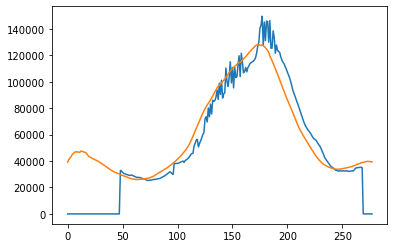

In [30]:
# predict hospitalizations in the future 

predictions = np.zeros(len(train))

for t in range(T + int_inf + delta2, len(train) - delta1):
    gm = pred_gammas[t]
    nb = U[t - delta2] + V[t - delta2]
    nb = (gm[0] + gm[1]) * nb
    predictions[t + 1] = nb * gm[0]
    

#plt.plot(np.arange(len(train)), predictions / np.amax(predictions))
#plt.plot(np.arange(len(train)), train[:, 1] / np.amax(train[:, 1]))

plt.plot(np.arange(len(train)), predictions)
plt.plot(np.arange(len(train)), train[:, 1])

In [33]:
print(complete_gammas[120])

[[0.03778001 0.97503637]
 [0.03774464 0.97571503]
 [0.03769795 0.97323831]
 [0.03784189 0.97072784]
 [0.03877376 0.96205625]
 [0.03904336 0.95839521]
 [0.03893511 0.95576822]
 [0.03907092 0.95539151]
 [0.03944154 0.95386544]
 [0.04000555 0.95256171]
 [0.04060771 0.95215403]
 [0.04109795 0.95622964]
 [0.04127788 0.95773018]
 [0.04154603 0.95719196]
 [1.         1.        ]]


In [73]:
print(cases_so_far)

[   80186.81318681   161329.67032967   243065.93406593   321923.07692308
   401450.54945055   479032.96703297   557714.28571429   635538.46153846
   714384.61538462   791670.32967033   871219.78021978   949010.98901099
  1027197.8021978   1102681.31868132  1177164.83516484  1250857.14285714
  1324329.67032967  1397912.08791209  1469593.40659341  1541417.58241758
  1611989.01098901  1682472.52747253  1751956.04395604  1822197.8021978
  1890153.84615385  1957153.84615385  2023285.71428571  2089208.79120879
  2153604.3956044   2218175.82417582  2280043.95604396  2335582.41758242
  2392010.98901099  2447109.89010989  2504582.41758242  2561395.6043956
  2617824.17582418  2675736.26373626  2741868.13186813  2805758.24175824
  2869043.95604396  2929274.72527472  2989835.16483516  3048527.47252747
  3107175.82417582  3163978.02197802  3221879.12087912  3280175.82417582
  3339000.          3398219.78021978  3457989.01098901  3517000.
  3573835.16483516  3629593.40659341  3685087.91208791  37396